In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#from ydata_profiling import ProfileReport

In [12]:
import sys
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")

!{sys.executable} -m pip install --break-system-packages kagglehub


Python executable: D:\Rostik\University\3_course\DataAnalysis\Anaconda\python.exe
Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]


In [15]:
import kagglehub
path = kagglehub.dataset_download("mosapabdelghany/medical-insurance-cost-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Ростик\.cache\kagglehub\datasets\mosapabdelghany\medical-insurance-cost-dataset\versions\1


In [16]:
#df = pd.read_csv("/root/.cache/kagglehub/datasets/mosapabdelghany/medical-insurance-cost-dataset/versions/1/insurance.csv")
df = pd.read_csv("./insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Задание 1

### Пропуски

In [18]:
print(df.columns.tolist())
print(df.isna().sum())

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


### Выбросы

In [19]:
def detect_outliers_iqr(df, columns=None):

    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns

    outliers_info = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        outliers_info[col] = {
            'count': len(outliers),
            'indices': outliers.index.tolist(),
            'values': outliers[col].tolist(),
            'bounds': (lower_bound, upper_bound)
        }

    return outliers_info

In [20]:
outliers = pd.DataFrame(detect_outliers_iqr(df))
outliers


,age,bmi,children,charges
count,0,9,0,139
indices,[],"[116, 286, 401, 543, 847, 860, 1047, 1088, 1317]",[],"[14, 19, 23, 29, 30, 34, 38, 39, 49, 53, 55, 8..."
values,[],"[49.06, 48.07, 47.52, 47.41, 50.38, 47.6, 52.5...",[],"[39611.7577, 36837.467, 37701.8768, 38711.0, 3..."
bounds,"(-9.0, 87.0)","(13.7, 47.290000000000006)","(-3.0, 5.0)","(-13109.1508975, 34489.350562499996)"


### Кодирование столбцов

#### Пол

In [21]:
gender_map = {'male': 1, 'female': 0}
df['sex'] = df['sex'].map(gender_map)

#### Курильщик

In [22]:
smoker_map = {'yes': 1, 'no': 0}
df['smoker'] = df['smoker'].map(smoker_map)

#### Регион

In [23]:
region_one_hot_encoded = pd.get_dummies(df['region'], drop_first=True).astype(int)
df = pd.concat([df, region_one_hot_encoded], axis=1)
df.drop(columns=['region'], inplace=True)

In [57]:
df

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1,0,0
1334,18,0,31.920,0,0,2205.98080,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,1


### Матрица корреляций

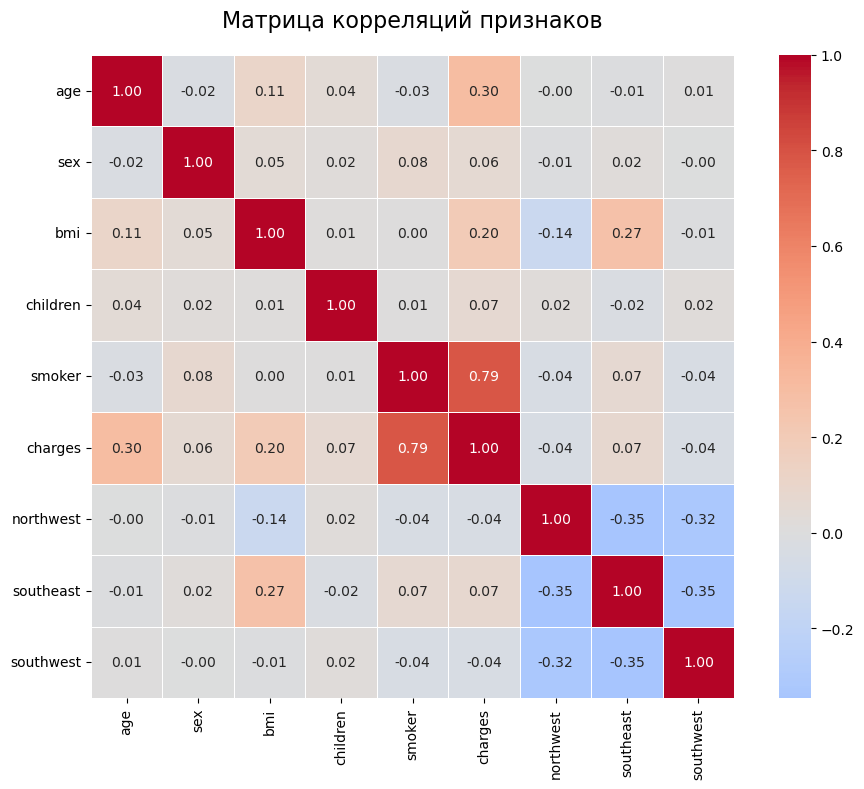

In [24]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            linewidths=0.5)

plt.title('Матрица корреляций признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## Задание 2 & 3

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['charges']), df['charges'], test_size=0.2, random_state=42)

In [26]:
y_train.shape[0], y_test.shape[0]

(1070, 268)

### Аналитическое решение

In [27]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

def analytical_linear_regression(X, y, l2=False, alpha=1.0, fit_intercept=True, return_metrics=True):
    X = np.array(X)
    y = np.array(y)

    if fit_intercept:
        X = np.column_stack([np.ones(X.shape[0]), X])

    try:
        if l2:
            n_features = X.shape[1]
            identity_matrix = np.eye(n_features)

            if fit_intercept:
                identity_matrix[0, 0] = 0

            XTX = X.T @ X
            XTX_regularized = XTX + alpha * identity_matrix

            w = np.linalg.inv(XTX_regularized) @ X.T @ y

        else:
            XTX = X.T @ X
            w = np.linalg.inv(XTX) @ X.T @ y

    except np.linalg.LinAlgError:
        print("Предупреждение: Матрица вырождена. Используем псевдообратную матрицу.")
        if l2:
            n_features = X.shape[1]
            identity_matrix = np.eye(n_features)
            if fit_intercept:
                identity_matrix[0, 0] = 0
            w = np.linalg.pinv(X.T @ X + alpha * identity_matrix) @ X.T @ y
        else:
            w = np.linalg.pinv(X.T @ X) @ X.T @ y

    y_pred = X @ w

    if return_metrics:
        metrics = calculate_metrics(y, y_pred, X.shape[1] - (1 if fit_intercept else 0))
        return w, metrics
    else:
        return w

def calculate_metrics(y_true, y_pred, n_features):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    n_samples = len(y_true)
    adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)

    return {
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'MAE': mae,
        'R2': r2,
        'Adjusted_R2': adj_r2
    }

def predict(X, w, fit_intercept=True):
    X = np.array(X)
    if fit_intercept:
        X = np.column_stack([np.ones(X.shape[0]), X])
    return X @ w

In [37]:
def plot_feature_importance(w, X_train):
    feature_names = ['Intercept'] + X_train.columns.tolist()
    weights_df = pd.DataFrame({
        'Признак': feature_names,
        'Вес': w
    })

    print("Веса модели:")
    print(weights_df)

    plt.figure(figsize=(10, 6))
    weights_no_intercept = weights_df[weights_df['Признак'] != 'Intercept'].copy()
    weights_no_intercept = weights_no_intercept.sort_values('Вес', ascending=True)

    plt.barh(weights_no_intercept['Признак'], weights_no_intercept['Вес'],
             color=['red' if x < 0 else 'green' for x in weights_no_intercept['Вес']])
    plt.xlabel('Вес признака', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.title('Важность признаков в модели', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [29]:
def evaluate_model(w, X_train, y_train, X_test, y_test, fit_intercept=True):

    y_pred_train = predict(X_train, w, fit_intercept=fit_intercept)
    metrics_train = calculate_metrics(y_train, y_pred_train, X_train.shape[1])

    y_pred_test = predict(X_test, w, fit_intercept=fit_intercept)
    metrics_test = calculate_metrics(y_test, y_pred_test, X_test.shape[1])

    results = pd.DataFrame({
        'Train': metrics_train,
        'Test': metrics_test
    }).T

    return results

#### Линейная регрессия без регуляризации

In [38]:
w_analytical, _ = analytical_linear_regression(X_train, y_train)

Веса модели:
     Признак           Вес
0  Intercept -11931.219050
1        age    256.975706
2        sex    -18.591692
3        bmi    337.092552
4   children    425.278784
5     smoker  23651.128856
6  northwest   -370.677326
7  southeast   -657.864297
8  southwest   -809.799354


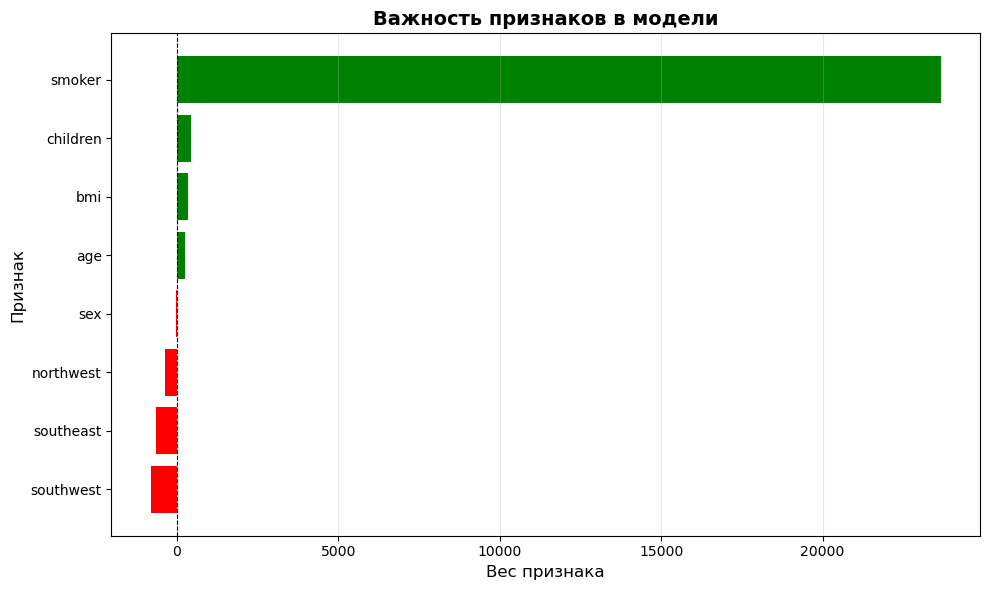

In [39]:
plot_feature_importance(w_analytical, X_train)

In [40]:
res_analytical = evaluate_model(w_analytical, X_train, y_train, X_test, y_test)
res_analytical

,MSE,RMSE,MAE,R2,Adjusted_R2
Train,3.727768e+07,6105.545160,4208.234572,0.741726,0.739778
Test,3.359692e+07,5796.284659,4181.194474,0.783593,0.776909


#### Линейная регрессия Ridge

In [41]:
w_analytical_ridge, _ = analytical_linear_regression(X_train, y_train, l2=True, alpha=1.0)

Веса модели:
     Признак           Вес
0  Intercept -11899.892753
1        age    256.782216
2        sex    -10.668326
3        bmi    336.877819
4   children    425.798686
5     smoker  23515.089451
6  northwest   -366.407914
7  southeast   -644.135484
8  southwest   -803.575305


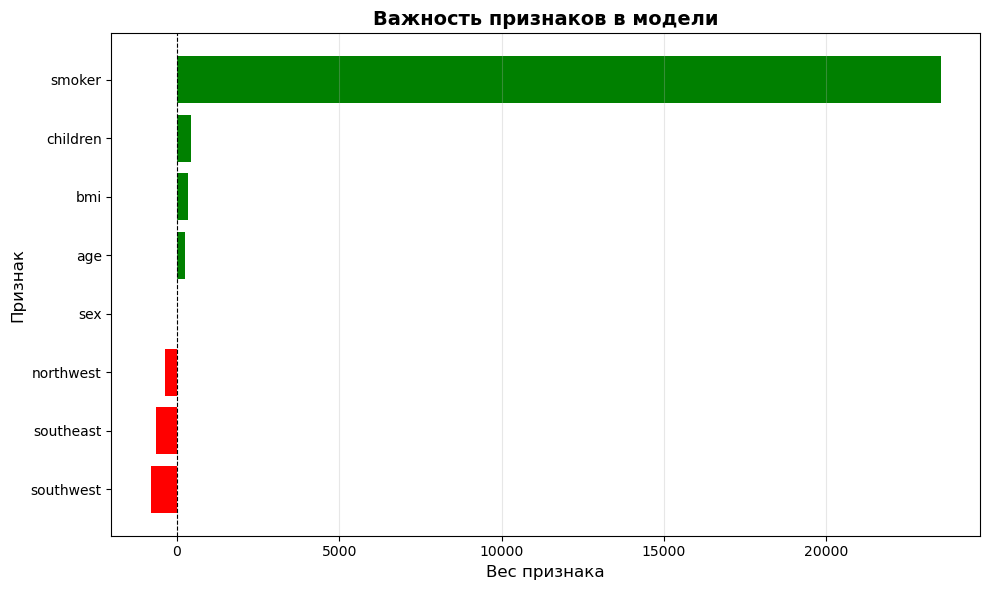

In [42]:
plot_feature_importance(w_analytical_ridge, X_train)

In [43]:
res_analytical_ridge = evaluate_model(w_analytical_ridge, X_train, y_train, X_test, y_test)
res_analytical_ridge

,MSE,RMSE,MAE,R2,Adjusted_R2
Train,3.728069e+07,6105.791168,4217.887372,0.741705,0.739757
Test,3.364504e+07,5800.434216,4193.585298,0.783283,0.776589


### Численное решение

In [70]:
def gradient_descent_regression(X, y, regularization=None, alpha=0.1, learning_rate=0.01,
                                n_iterations=1000, fit_intercept=True, return_metrics=True,
                                return_history=False, verbose=False):
    X = np.array(X)
    y = np.array(y)

    n_samples, n_features = X.shape

    if fit_intercept:
        X = np.column_stack([np.ones(n_samples), X])

    w = np.random.randn(X.shape[1]) * 0.01

    loss_history = []

    for iteration in range(n_iterations):
        y_pred = X @ w

        error = y_pred - y

        gradient = (2 / n_samples) * (X.T @ error)

        if regularization == 'l2':
            reg_gradient = 2 * alpha * w
            if fit_intercept:
                reg_gradient[0] = 0
            gradient += reg_gradient

        elif regularization == 'l1':
            reg_gradient = alpha * np.sign(w)
            if fit_intercept:
                reg_gradient[0] = 0
            gradient += reg_gradient

        w = w - learning_rate * gradient

        mse = np.mean(error ** 2)
        loss = mse

        if regularization == 'l2':
            reg_loss = alpha * np.sum(w[1:] ** 2) if fit_intercept else alpha * np.sum(w ** 2)
            loss += reg_loss
        elif regularization == 'l1':
            reg_loss = alpha * np.sum(np.abs(w[1:])) if fit_intercept else alpha * np.sum(np.abs(w))
            loss += reg_loss

        loss_history.append(loss)

        if verbose and (iteration % 100 == 0 or iteration == n_iterations - 1):
            print(f"Iteration {iteration}: Loss = {loss:.4f}, MSE = {mse:.4f}")

    y_pred = X @ w

    results = [w]

    if return_metrics:
        n_features_for_metrics = X.shape[1] - (1 if fit_intercept else 0)
        metrics = calculate_metrics(y, y_pred, n_features_for_metrics)
        results.append(metrics)

    if return_history:
        history = {
            'loss': loss_history,
            'final_loss': loss_history[-1]
        }
        results.append(history)

    if len(results) == 1:
        return results[0]
    else:
        return tuple(results)

In [71]:
# Функция для получения метрик в исходной шкале
def evaluate_model_scaled(w, X_train, y_train, X_test, y_test,
                          X_scaler, y_scaler, fit_intercept=True):
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    y_pred_train_scaled = predict(X_train_scaled, w, fit_intercept=fit_intercept)
    y_pred_test_scaled = predict(X_test_scaled, w, fit_intercept=fit_intercept)

    y_pred_train = y_scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).ravel()
    y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()

    metrics_train = calculate_metrics(y_train, y_pred_train, X_train.shape[1])
    metrics_test = calculate_metrics(y_test, y_pred_test, X_test.shape[1])

    results = pd.DataFrame({
        'Train': metrics_train,
        'Test': metrics_test
    }).T

    return results


In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

In [73]:
w_gd, metrics_gd_scaled, history_gd = gradient_descent_regression(
    X_train_scaled, y_train_scaled,
    learning_rate=0.01,
    n_iterations=5000,
    return_history=True,
    verbose=True
)
print("   l2   \n")
w_gd_ridge, metrics_gd_ridge_scaled, history_ridge = gradient_descent_regression(
    X_train_scaled, y_train_scaled,
    regularization='l2',
    alpha=0.1,
    learning_rate=0.01,
    n_iterations=5000,
    return_history=True,
    verbose=True
)
print("      l1    \n")
w_gd_lasso, metrics_gd_lasso_scaled, history_lasso = gradient_descent_regression(
    X_train_scaled, y_train_scaled,
    regularization='l1',
    alpha=0.1,
    learning_rate=0.01,
    n_iterations=5000,
    return_history=True,
    verbose=True
)

Iteration 0: Loss = 0.9946, MSE = 0.9946
Iteration 100: Loss = 0.2732, MSE = 0.2732
Iteration 200: Loss = 0.2587, MSE = 0.2587
Iteration 300: Loss = 0.2583, MSE = 0.2583
Iteration 400: Loss = 0.2583, MSE = 0.2583
Iteration 500: Loss = 0.2583, MSE = 0.2583
Iteration 600: Loss = 0.2583, MSE = 0.2583
Iteration 700: Loss = 0.2583, MSE = 0.2583
Iteration 800: Loss = 0.2583, MSE = 0.2583
Iteration 900: Loss = 0.2583, MSE = 0.2583
Iteration 1000: Loss = 0.2583, MSE = 0.2583
Iteration 1100: Loss = 0.2583, MSE = 0.2583
Iteration 1200: Loss = 0.2583, MSE = 0.2583
Iteration 1300: Loss = 0.2583, MSE = 0.2583
Iteration 1400: Loss = 0.2583, MSE = 0.2583
Iteration 1500: Loss = 0.2583, MSE = 0.2583
Iteration 1600: Loss = 0.2583, MSE = 0.2583
Iteration 1700: Loss = 0.2583, MSE = 0.2583
Iteration 1800: Loss = 0.2583, MSE = 0.2583
Iteration 1900: Loss = 0.2583, MSE = 0.2583
Iteration 2000: Loss = 0.2583, MSE = 0.2583
Iteration 2100: Loss = 0.2583, MSE = 0.2583
Iteration 2200: Loss = 0.2583, MSE = 0.2583


#### Линейная регрессия

In [74]:
res_gd = evaluate_model_scaled(w_gd, X_train, y_train, X_test, y_test, scaler, y_scaler)
res_gd

,MSE,RMSE,MAE,R2,Adjusted_R2
Train,3.727768e+07,6105.545160,4208.234572,0.741726,0.739778
Test,3.359692e+07,5796.284659,4181.194474,0.783593,0.776909


Веса модели:
     Признак           Вес
0  Intercept  1.458453e-16
1        age  3.008996e-01
2        sex -7.735295e-04
3        bmi  1.694895e-01
4   children  4.302438e-02
5     smoker  7.956190e-01
6  northwest -1.316318e-02
7  southeast -2.415179e-02
8  southwest -2.905891e-02


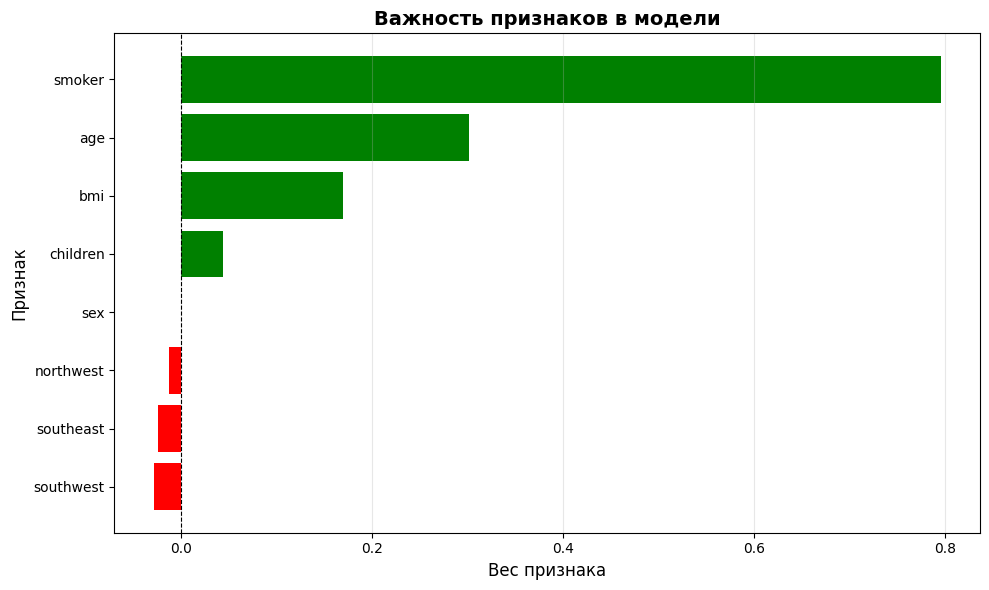

In [75]:
plot_feature_importance(w_gd, X_train)

#### Линейная регрессия + L2

In [76]:
res_gd_ridge = evaluate_model_scaled(w_gd_ridge, X_train, y_train, X_test, y_test, scaler, y_scaler)
res_gd_ridge

,MSE,RMSE,MAE,R2,Adjusted_R2
Train,3.820395e+07,6180.934386,4361.728269,0.735308,0.733312
Test,3.533400e+07,5944.240643,4378.647501,0.772404,0.765374


Веса модели:
     Признак           Вес
0  Intercept  1.584197e-16
1        age  2.717444e-01
2        sex  4.199253e-03
3        bmi  1.546299e-01
4   children  4.170961e-02
5     smoker  7.212860e-01
6  northwest -1.018822e-02
7  southeast -1.289429e-02
8  southwest -2.352377e-02


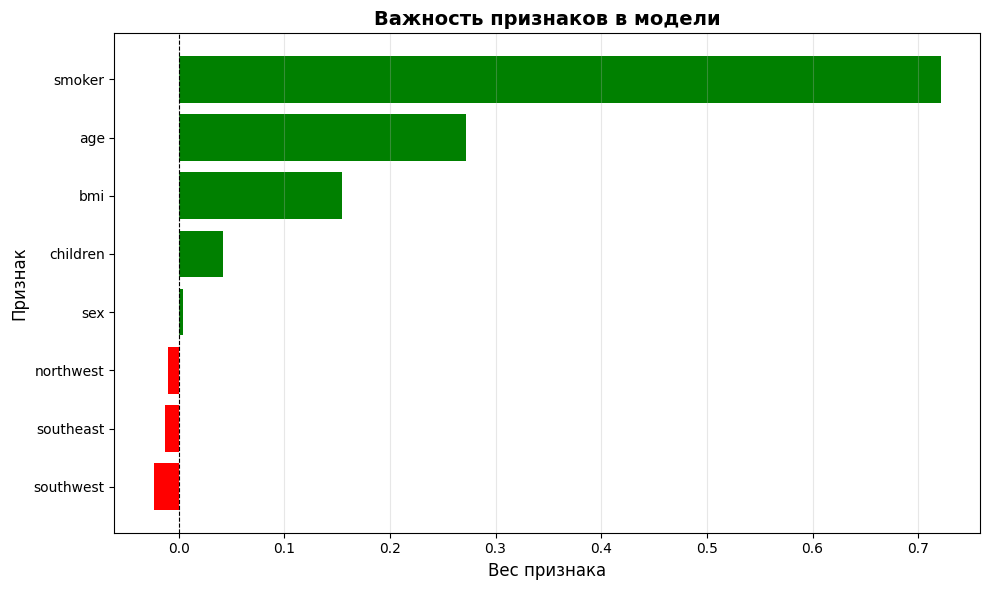

In [77]:
plot_feature_importance(w_gd_ridge, X_train)

#### Линейная регрессия + L1

In [78]:
res_gd_lasso = evaluate_model_scaled(w_gd_lasso, X_train, y_train, X_test, y_test, scaler, y_scaler)
res_gd_lasso

,MSE,RMSE,MAE,R2,Adjusted_R2
Train,3.866576e+07,6218.179443,4312.194875,0.732108,0.730089
Test,3.588352e+07,5990.285615,4307.115590,0.768864,0.761725


Веса модели:
     Признак           Вес
0  Intercept  1.361440e-16
1        age  2.562409e-01
2        sex  5.098161e-04
3        bmi  1.195390e-01
4   children  1.502793e-03
5     smoker  7.437727e-01
6  northwest  4.170171e-05
7  southeast -3.130189e-04
8  southwest  4.419036e-04


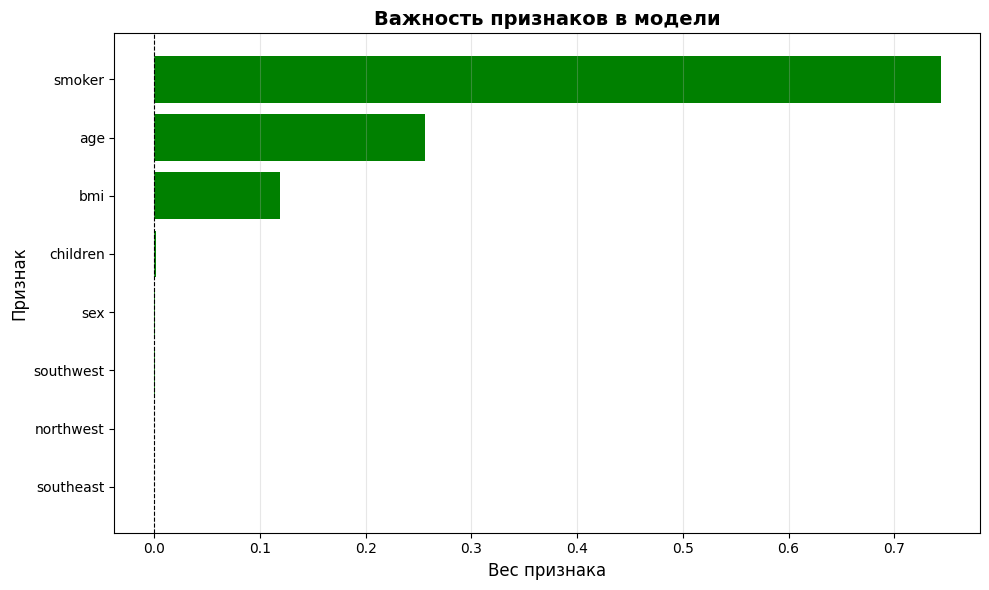

In [79]:
plot_feature_importance(w_gd_lasso, X_train)

### Предсказание средним

In [44]:
# Baseline модель - предсказание средним значением
def evaluate_mean_baseline(y_train, y_test):
    mean_value = np.mean(y_train)

    y_pred_train = np.full_like(y_train, mean_value, dtype=float)
    y_pred_test = np.full_like(y_test, mean_value, dtype=float)

    metrics_train = calculate_metrics(y_train, y_pred_train, n_features=0)
    metrics_test = calculate_metrics(y_test, y_pred_test, n_features=0)

    results = pd.DataFrame({
        'Train': metrics_train,
        'Test': metrics_test
    }).T

    return results

res_mean = evaluate_mean_baseline(y_train, y_test)

print(f"\nБазовое предсказание: {np.mean(y_train):.2f}")
res_mean


Базовое предсказание: 13346.09


,MSE,RMSE,MAE,R2,Adjusted_R2
Train,1.443336e+08,12013.892872,9000.556130,0.000000,0.000000
Test,1.553914e+08,12465.610442,9593.338461,-0.000919,-0.000919


## Задание 4

### Сравнение на тестовой выборке

In [81]:
comparison = pd.DataFrame({
    'Mean Baseline': res_mean.loc['Test'],
    'Analytical': res_analytical.loc['Test'],
    'Analytical Ridge': res_analytical_ridge.loc['Test'],
    'GD': res_gd.loc['Test'],
    'GD + Ridge': res_gd_ridge.loc['Test'],
    'GD + Lasso': res_gd_lasso.loc['Test']
}).T

print("\n" + "="*60)
print("СРАВНЕНИЕ ВСЕХ МЕТОДОВ (Test set)")
print("="*60)
comparison


СРАВНЕНИЕ ВСЕХ МЕТОДОВ (Test set)


,MSE,RMSE,MAE,R2,Adjusted_R2
Mean Baseline,1.553914e+08,12465.610442,9593.338461,-0.000919,-0.000919
Analytical,3.359692e+07,5796.284659,4181.194474,0.783593,0.776909
Analytical Ridge,3.364504e+07,5800.434216,4193.585298,0.783283,0.776589
GD,3.359692e+07,5796.284659,4181.194474,0.783593,0.776909
GD + Ridge,3.533400e+07,5944.240643,4378.647501,0.772404,0.765374
GD + Lasso,3.588352e+07,5990.285615,4307.115590,0.768864,0.761725
